In [1]:
import torch
import super_gradients

print(torch.__version__)
print(super_gradients.__version__)

In [ ]:
# !pip install imutils
# !pip install pytube
# !pip install roboflow

  You can safely remove it manually.


In [2]:
from super_gradients.training import Trainer,dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train,coco_detection_yolo_format_val

In [3]:
from IPython.display import clear_output

In [4]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import models


In [5]:
checkpoint_dir = 'C:\\Users\\Admin\\Desktop\\Yolo\\Checkpoint'
trainer = Trainer(experiment_name='FaceMaskDetection',ckpt_root_dir=checkpoint_dir)

In [6]:
from roboflow import Roboflow
rf = Roboflow(api_key="zVTcvgXZEjc4ds2sz2eS")
project = rf.workspace("charusat-7vcto").project("facemaskdetection-4sca8")
version = project.version(1)
dataset = version.download("yolov5")

In [7]:
dataset_params = {
'data_dir':'C:\\Users\\Admin\\Desktop\\Yolo\\FaceMaskDetection-1',
'train_images_dir': 'train/images',
'train_labels_dir': 'train/labels',
'val_images_dir': 'valid/images',
'val_labels_dir': 'valid/labels',
'test_images_dir':'test/images',
'test_labels_dir': 'test/labels',
'classes': ['mask_weared_incorrect', 'with_mask', 'without_mask']
}

In [8]:
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 16,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 16,
        'num_workers': 2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 16,
        'num_workers': 2
    }
)

Indexing dataset annotations:  35%|███▌      | 30/85 [00:00<00:00, 296.12it/s]

Indexing dataset annotations: 100%|██████████| 85/85 [00:00<00:00, 277.09it/s]


In [9]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

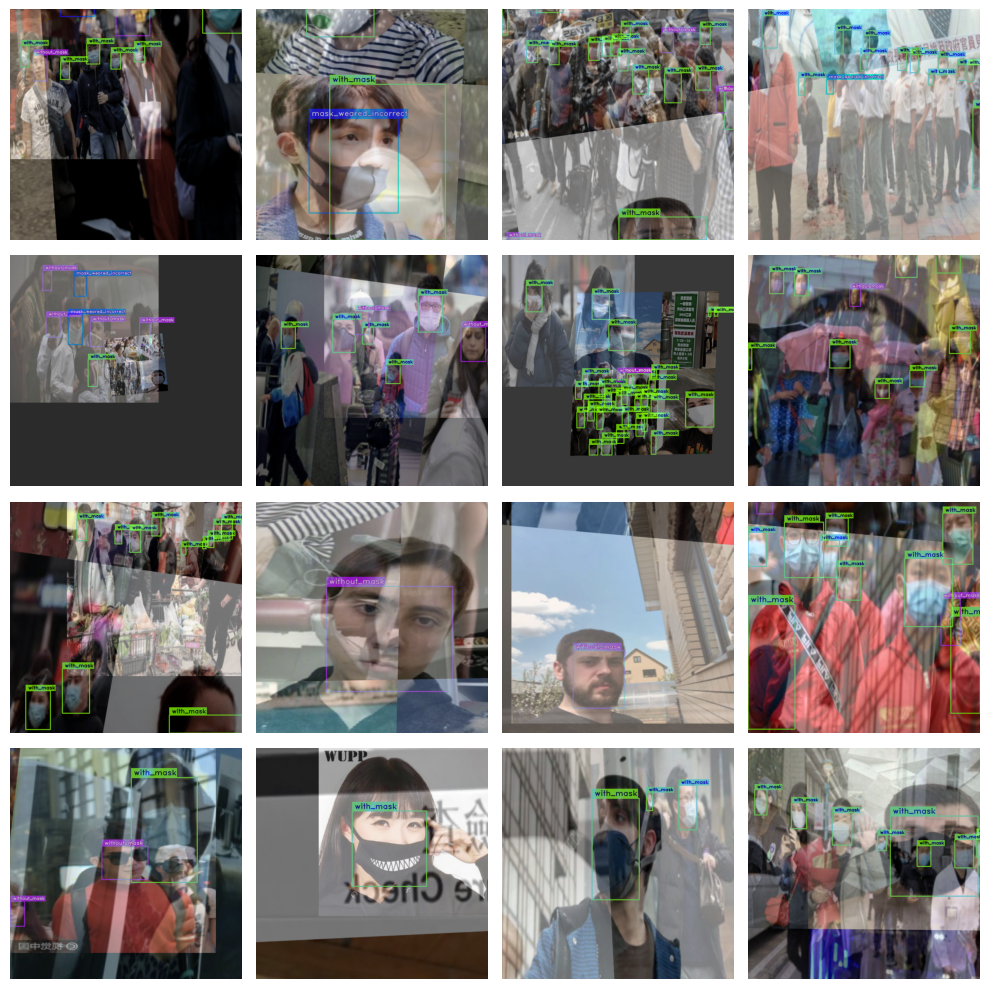

In [10]:
train_data.dataset.plot()

In [24]:
model = models.get(
    "yolo_nas_s",
    num_classes=3,
    checkpoint_path="yolo_nas_s_coco.pth",
    load_backbone=True
)


In [30]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 15,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [31]:
trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)

Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Validating: 100%|██████████| 11/11 [01:04<00:00,  5.86s/it]


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray._reconstruct was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy.core.multiarray._reconstruct])` or the `torch.serialization.safe_globals([numpy.core.multiarray._reconstruct])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.